In [3]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pymongo
from pymongo import MongoClient
import json

%matplotlib inline

In [35]:
def get_database():
    
    CONNECTION_STRING = "mongodb+srv://admin:<password>@<cluster>"
    client = MongoClient(CONNECTION_STRING)
    return client['oct30']

def load_df_to_mongo_db(collectionName, dataframe):
    
    records = json.loads(dataframe.T.to_json()).values()
    mongo_db = get_database()
    collection = mongo_db[collectionName]
    collection.delete_many({}) # just to make sure only the latest entries are kept in collection
    collection.insert_many(records)
    

In [5]:
data = pd.read_csv('household_power_consumption/household_power_consumption.txt',delimiter=';')

C:\Users\ymurugan\AppData\Local\Temp\ipykernel_30740\3603126926.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('household_power_consumption/household_power_consumption.txt',delimiter=';')


In [6]:
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [7]:
data.shape # Since the size of data is large we will select randomly select 150000 rows
data = data.sample(n=150000)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 907371 to 1887502
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Date                   150000 non-null  object 
 1   Time                   150000 non-null  object 
 2   Global_active_power    150000 non-null  object 
 3   Global_reactive_power  150000 non-null  object 
 4   Voltage                150000 non-null  object 
 5   Global_intensity       150000 non-null  object 
 6   Sub_metering_1         150000 non-null  object 
 7   Sub_metering_2         150000 non-null  object 
 8   Sub_metering_3         148037 non-null  float64
dtypes: float64(1), object(8)
memory usage: 11.4+ MB


In [9]:
data.isnull().sum() # we have null values in the colum sub_metering_3

Date                        0
Time                        0
Global_active_power         0
Global_reactive_power       0
Voltage                     0
Global_intensity            0
Sub_metering_1              0
Sub_metering_2              0
Sub_metering_3           1963
dtype: int64

### Attribute Information:

1) date: Date in format dd/mm/yyyy

2) time: time in format hh:mm:ss

3) global_active_power: household global minute-averaged active power (in kilowatt)

4) global_reactive_power: household global minute-averaged reactive power (in kilowatt)

5) voltage: minute-averaged voltage (in volt)

6) global_intensity: household global minute-averaged current intensity (in ampere)

7) sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8) sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9) sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

### Data cleaning/processing

#### We can see that there are many feature which are in object type which should be coverted to float or int type

In [10]:
data[["day", "month", "year"]] = data["Date"].str.split("/", expand = True)
data['Time'] = pd.to_timedelta(data['Time'])

In [11]:
data['TimeInMinute'] = data['Time'].dt.total_seconds().div(60).astype(int)+1
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year,TimeInMinute
907371,6/9/2008,0 days 20:15:00,2.536,0.096,237.990,11.000,0.000,0.000,18.0,6,9,2008,1216
1506398,27/10/2009,0 days 20:02:00,1.610,0.000,239.030,6.600,0.000,0.000,1.0,27,10,2009,1203
167519,12/4/2007,0 days 01:23:00,0.214,0.000,239.910,0.800,0.000,0.000,0.0,12,4,2007,84
1635398,25/1/2010,0 days 10:02:00,1.506,0.212,242.780,6.200,0.000,1.000,19.0,25,1,2010,603
1273497,19/5/2009,0 days 02:21:00,0.254,0.000,241.800,1.000,0.000,0.000,1.0,19,5,2009,142


In [12]:
numericColums = [col for col in data.columns if col not in {'Date','Time'}]
data[numericColums] = data[numericColums].apply(pd.to_numeric,errors='coerce')

In [13]:
data.info() # There are some significunt amount of null values which are need to be handled

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 907371 to 1887502
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype          
---  ------                 --------------   -----          
 0   Date                   150000 non-null  object         
 1   Time                   150000 non-null  timedelta64[ns]
 2   Global_active_power    148037 non-null  float64        
 3   Global_reactive_power  148037 non-null  float64        
 4   Voltage                148037 non-null  float64        
 5   Global_intensity       148037 non-null  float64        
 6   Sub_metering_1         148037 non-null  float64        
 7   Sub_metering_2         148037 non-null  float64        
 8   Sub_metering_3         148037 non-null  float64        
 9   day                    150000 non-null  int64          
 10  month                  150000 non-null  int64          
 11  year                   150000 non-null  int64          
 12  TimeInMinute           1

In [14]:
data = data.drop(['Time','Date'],axis = 1)

In [15]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year,TimeInMinute
907371,2.536,0.096,237.99,11.0,0.0,0.0,18.0,6,9,2008,1216
1506398,1.610,0.000,239.03,6.6,0.0,0.0,1.0,27,10,2009,1203
167519,0.214,0.000,239.91,0.8,0.0,0.0,0.0,12,4,2007,84
1635398,1.506,0.212,242.78,6.2,0.0,1.0,19.0,25,1,2010,603
1273497,0.254,0.000,241.80,1.0,0.0,0.0,1.0,19,5,2009,142


### EDA

### Univariate analysis

In [16]:
# define numerical & categorical columns
numeric_features = [feature for feature in data.columns if data[feature].dtype != 'O']
categorical_features = [feature for feature in data.columns if data[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 11 numerical features : ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'day', 'month', 'year', 'TimeInMinute']

We have 0 categorical features : []


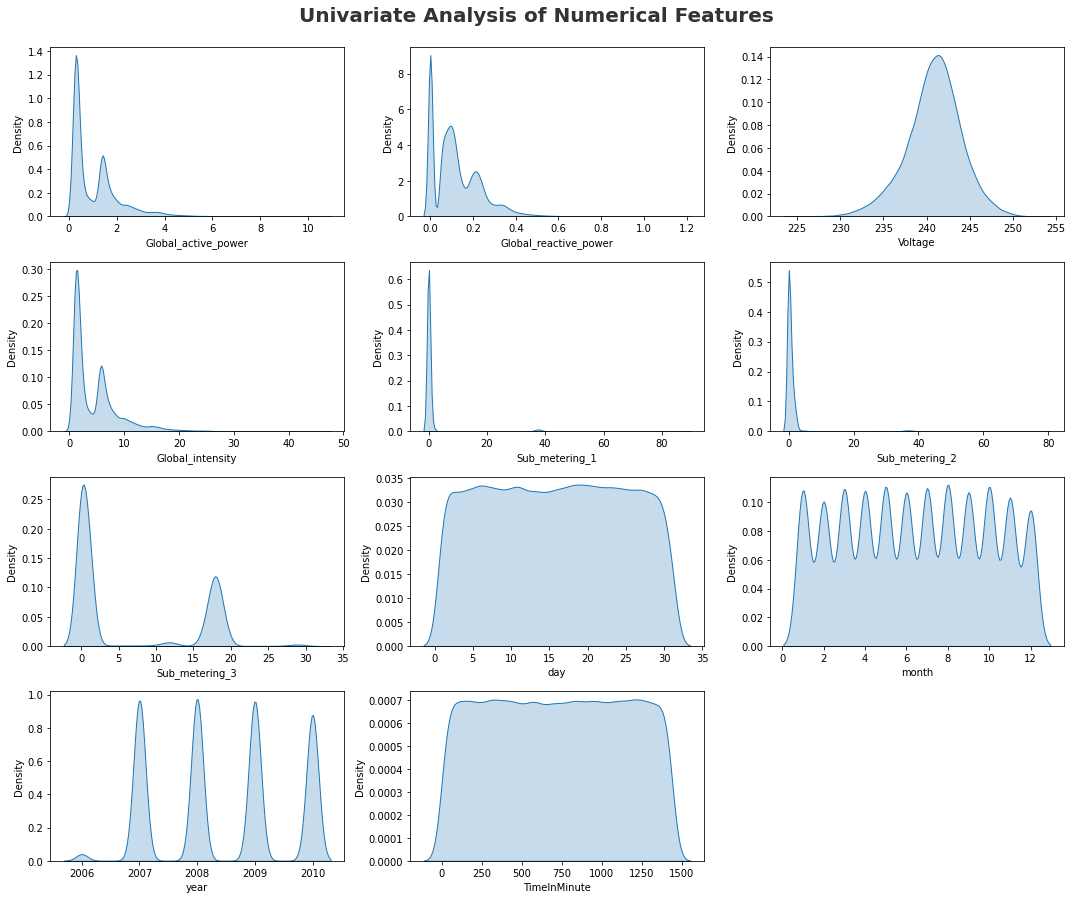

In [17]:
plt.figure(figsize=(15, 15))
plt.suptitle('Univariate Analysis of Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(numeric_features)):
    plt.subplot(5, 3, i+1)
    sns.kdeplot(x=data[numeric_features[i]],fill=True,palette="crest")
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

#### Observations
1) We can neglate the distribution for year, timeinminute, day and month

2) Sub_metering 1,2 and 3 seems to right skewed which says people usally consume more electricty during morning period.
   So we can combine these three features and make into one during the feature engineering process

3) Volatage is normally distributed

Num of continues features : ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'day', 'month', 'TimeInMinute']


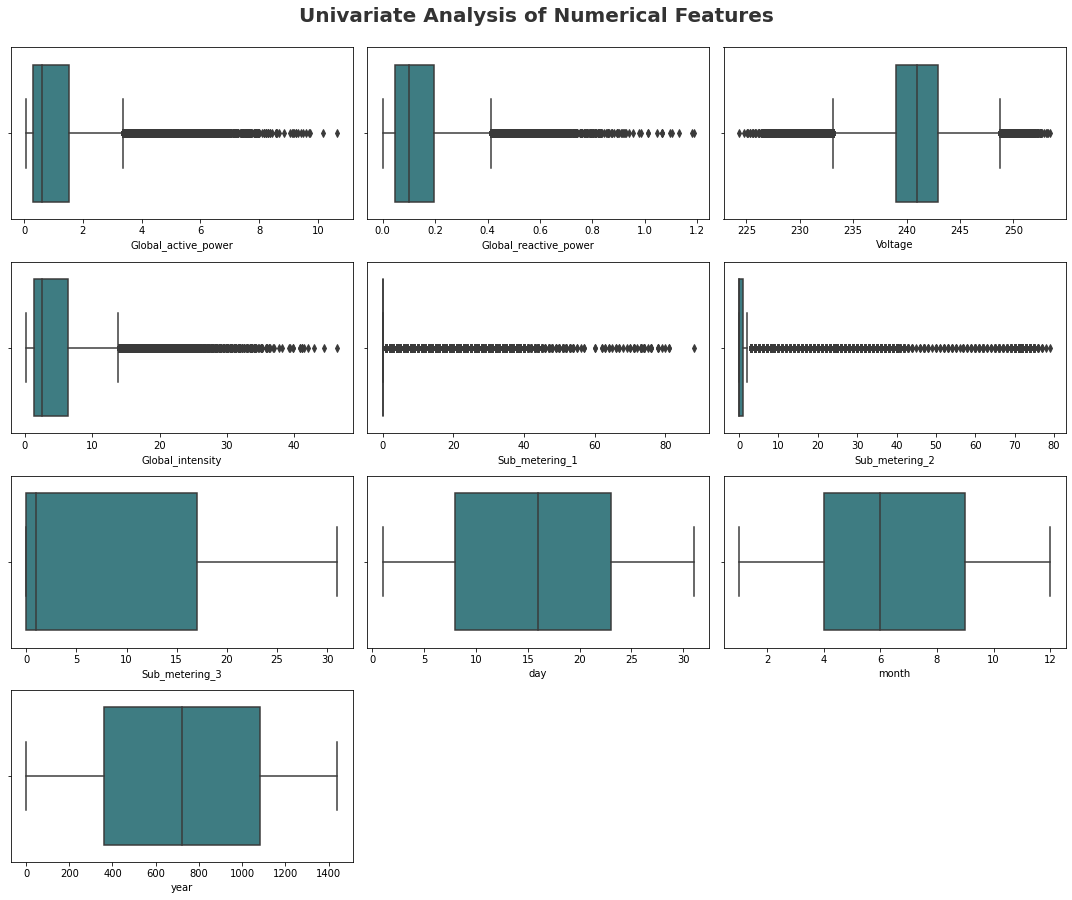

In [18]:
continues_features=[feature for feature in numeric_features if len(data[feature].unique())>=10]
print('Num of continues features :',continues_features)

plt.figure(figsize=(15, 15))
plt.suptitle('Univariate Analysis of Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)


for i in range(0, len(continues_features)):
    plt.subplot(5, 3, i+1)
    sns.boxplot(x=data[continues_features[i]],palette="crest")
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

### Bivariate analysis

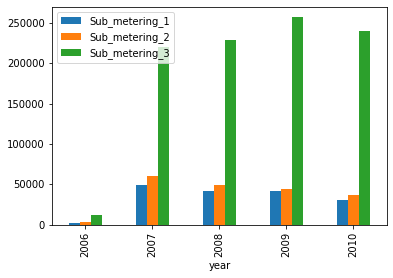

In [19]:
groupByYear = data.groupby(['year']).sum()
groupByYear[['Sub_metering_1','Sub_metering_2','Sub_metering_3']].plot(kind = 'bar')
groupByYear['total_sub_metering'] = groupByYear['Sub_metering_1'] + groupByYear['Sub_metering_2'] + groupByYear['Sub_metering_1']

In [20]:
groupByYear 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,TimeInMinute,total_sub_metering
year,,,,,,,,,,,
2006,3027.104,202.356,380548.84,12770.0,2072.0,3514.0,11306.0,37637,18912,1129425,7658.0
2007,42300.604,4424.512,9014291.23,180424.2,48503.0,60726.0,219846.0,595994,247960,27383006,157732.0
2008,40729.256,4478.918,9207640.82,173026.2,41157.0,49601.0,228882.0,602762,249013,27588228,131915.0
2009,40395.518,4913.570,9043505.90,170592.0,41132.0,43589.0,256729.0,590964,246571,27051845,125853.0
2010,35071.844,4263.678,8006369.58,148007.0,30938.0,36941.0,240388.0,537426,205604,24858614,98817.0


#### we can see that the maximum submeter consumption has happened on year 2007

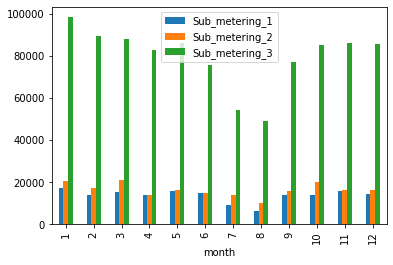

In [21]:
groupByMonth = data.groupby(['month']).sum()
groupByMonth[['Sub_metering_1','Sub_metering_2','Sub_metering_3']].plot(kind = 'bar')
groupByMonth['total_sub_metering'] = groupByMonth['Sub_metering_1'] + groupByMonth['Sub_metering_2'] + groupByMonth['Sub_metering_1']

In [22]:
groupByMonth

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,year,TimeInMinute,total_sub_metering
month,,,,,,,,,,,
1,18382.706,1389.458,3032170.30,77161.4,17179.0,20494.0,98412.0,203566,25620287,9214343,54852.0
2,15513.162,1187.856,2834249.34,64999.6,13986.0,16935.0,89426.0,171417,23589872,8556519,44907.0
3,15563.418,1381.894,3052583.20,65450.6,15323.0,20999.0,87878.0,205591,25704933,9241375,51645.0
4,12831.786,1510.864,2975538.79,54229.0,13631.0,13715.0,82549.0,194566,25355229,9098543,40977.0
5,13239.734,1639.844,3101321.40,56612.0,15930.0,16258.0,86100.0,208725,26058441,9288528,48118.0
6,10922.666,1797.598,2939762.18,47190.0,14725.0,14519.0,75503.0,194024,25076071,8948235,43969.0
7,9031.712,1971.142,3080402.74,39533.8,9156.0,13828.0,54299.0,204112,25789181,9252200,32140.0
8,7231.168,1733.784,3006951.29,31738.4,6017.0,10110.0,49042.0,211505,26399569,9462248,22144.0
9,11827.808,1600.170,2905859.46,50543.0,13919.0,15517.0,77120.0,194222,25094059,8962006,43355.0


#### submeter consumption is high during the 1st half of the year. May be thats the summer time for them

## Multivariate analysis

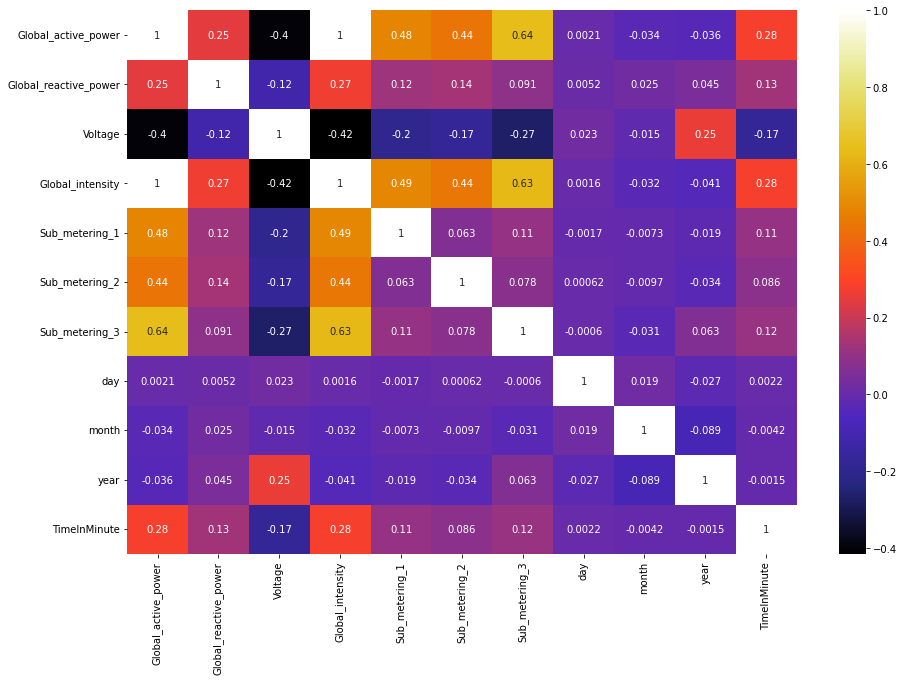

In [23]:
plt.figure(figsize = (15,10))
sns.heatmap(data.corr(), cmap="CMRmap", annot=True)
plt.show()

### Feature Engineering
#### Lets perform some feature engineering and analysis the corillation after that

In [24]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year,TimeInMinute
907371,2.536,0.096,237.99,11.0,0.0,0.0,18.0,6,9,2008,1216
1506398,1.610,0.000,239.03,6.6,0.0,0.0,1.0,27,10,2009,1203
167519,0.214,0.000,239.91,0.8,0.0,0.0,0.0,12,4,2007,84
1635398,1.506,0.212,242.78,6.2,0.0,1.0,19.0,25,1,2010,603
1273497,0.254,0.000,241.80,1.0,0.0,0.0,1.0,19,5,2009,142


In [25]:
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year,TimeInMinute
count,148037.000000,148037.000000,148037.000000,148037.000000,148037.000000,148037.000000,148037.000000,150000.00000,150000.000000,150000.000000,150000.00000
mean,1.091108,0.123503,240.834091,4.626002,1.106494,1.312989,6.465620,15.76522,6.453733,2008.437307,720.07412
std,1.058127,0.112597,3.246852,4.449721,6.109426,5.883775,8.431999,8.79456,3.407150,1.129217,416.24351
min,0.076000,0.000000,224.320000,0.200000,0.000000,0.000000,0.000000,1.00000,1.000000,2006.000000,1.00000
25%,0.308000,0.048000,238.980000,1.400000,0.000000,0.000000,0.000000,8.00000,4.000000,2007.000000,359.00000
50%,0.600000,0.100000,241.010000,2.600000,0.000000,0.000000,1.000000,16.00000,6.000000,2008.000000,720.00000
75%,1.530000,0.194000,242.890000,6.400000,0.000000,1.000000,17.000000,23.00000,9.000000,2009.000000,1081.00000
max,10.650000,1.186000,253.420000,46.400000,88.000000,79.000000,31.000000,31.00000,12.000000,2010.000000,1440.00000


In [26]:
#replacing the null values with median becuase there are lot of outliers we found
Sub_metering_1_median=data['Sub_metering_1'].median()
Sub_metering_2_median=data['Sub_metering_2'].median()
Sub_metering_3_median=data['Sub_metering_3'].median()
Global_active_power_median=data['Global_active_power'].median()
Global_reactive_power_median=data['Global_reactive_power'].median()
Voltage_median=data['Voltage'].median()
Global_intensity_median=data['Global_intensity'].median()

data['Sub_metering_1'].fillna(value=Sub_metering_1_median, inplace=True)
data['Sub_metering_2'].fillna(value=Sub_metering_2_median, inplace=True)
data['Sub_metering_3'].fillna(value=Sub_metering_3_median, inplace=True)
data['Global_active_power'].fillna(value=Global_active_power_median, inplace=True)
data['Global_reactive_power'].fillna(value=Global_reactive_power_median, inplace=True)
data['Voltage'].fillna(value=Voltage_median, inplace=True)
data['Global_intensity'].fillna(value=Global_intensity_median, inplace=True)


In [27]:
data.info() # We have handled handled missing values with median

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 907371 to 1887502
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Global_active_power    150000 non-null  float64
 1   Global_reactive_power  150000 non-null  float64
 2   Voltage                150000 non-null  float64
 3   Global_intensity       150000 non-null  float64
 4   Sub_metering_1         150000 non-null  float64
 5   Sub_metering_2         150000 non-null  float64
 6   Sub_metering_3         150000 non-null  float64
 7   day                    150000 non-null  int64  
 8   month                  150000 non-null  int64  
 9   year                   150000 non-null  int64  
 10  TimeInMinute           150000 non-null  int32  
dtypes: float64(7), int32(1), int64(3)
memory usage: 17.2 MB


In [28]:
data['Sub_metering'] = data['Sub_metering_1'] + data['Sub_metering_2'] + data['Sub_metering_3']

In [29]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year,TimeInMinute,Sub_metering
907371,2.536,0.096,237.99,11.0,0.0,0.0,18.0,6,9,2008,1216,18.0
1506398,1.610,0.000,239.03,6.6,0.0,0.0,1.0,27,10,2009,1203,1.0
167519,0.214,0.000,239.91,0.8,0.0,0.0,0.0,12,4,2007,84,0.0
1635398,1.506,0.212,242.78,6.2,0.0,1.0,19.0,25,1,2010,603,20.0
1273497,0.254,0.000,241.80,1.0,0.0,0.0,1.0,19,5,2009,142,1.0


In [30]:
data.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year,TimeInMinute,Sub_metering
Global_active_power,1.000000,0.248316,-0.403381,0.998886,0.485104,0.439660,0.640493,-0.001309,-0.032808,-0.041148,0.278750,0.848717
Global_reactive_power,0.248316,1.000000,-0.116133,0.267256,0.121652,0.137963,0.092005,0.003674,0.025522,0.042326,0.126218,0.180562
Voltage,-0.403381,-0.116133,1.000000,-0.415150,-0.199127,-0.170037,-0.268097,0.023416,-0.015090,0.251732,-0.173683,-0.347024
Global_intensity,0.998886,0.267256,-0.415150,1.000000,0.490118,0.445385,0.628308,-0.001749,-0.031658,-0.045354,0.279044,0.845723
Sub_metering_1,0.485104,0.121652,-0.199127,0.490118,1.000000,0.063277,0.106469,-0.003028,-0.007054,-0.020686,0.106253,0.571360
Sub_metering_2,0.439660,0.137963,-0.170037,0.445385,0.063277,1.000000,0.080020,-0.001029,-0.009403,-0.035625,0.085967,0.537742
Sub_metering_3,0.640493,0.092005,-0.268097,0.628308,0.106469,0.080020,1.000000,-0.005381,-0.030517,0.055060,0.114559,0.741092
day,-0.001309,0.003674,0.023416,-0.001749,-0.003028,-0.001029,-0.005381,1.000000,0.019004,-0.026575,0.002181,-0.005421
month,-0.032808,0.025522,-0.015090,-0.031658,-0.007054,-0.009403,-0.030517,0.019004,1.000000,-0.088968,-0.004244,-0.027586
year,-0.041148,0.042326,0.251732,-0.045354,-0.020686,-0.035625,0.055060,-0.026575,-0.088968,1.000000,-0.001514,0.010018


#### Observation
1) We see same level of corrillation for Global_active_power and Global_reactive_power with the target variable so any one can removed

2) We see no corrilation with day year and month with target variable (sub_metering) so we can drop it

In [31]:
data = data.drop(['Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3','day','month','year'],axis=1)

In [32]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,TimeInMinute,Sub_metering
907371,2.536,0.096,237.99,1216,18.0
1506398,1.610,0.000,239.03,1203,1.0
167519,0.214,0.000,239.91,84,0.0
1635398,1.506,0.212,242.78,603,20.0
1273497,0.254,0.000,241.80,142,1.0


### Exporting data to mongodb

In [36]:
load_df_to_mongo_db('regression',data)

C:\Users\ymurugan\Anaconda3\envs\reserve\lib\site-packages\pymongo\common.py:813: UserWarning: The value of retrywrites must be 'true' or 'false'
  warnings.warn(str(exc))
